# Introduction:
* This notebook contains an analysis of the "Titanic" dataset from kaggle: https://www.kaggle.com/c/titanic.
* The goal is to train a model that gets the highest accuracy score for the test data provided by kaggle.

#### The notebook is divided into the following stages:
* [Part 1: Notebook preparation](#part_1): [Import](#import), [Config](#config), [Functions](#functions)
* [Part 2: Data exploration](#part_2)
* [Part 3: Feature engineering](#part_3)
* [Part 4: Feature analysis](#part_4): [Lifts](#lifts), [Trends](#trends), [Correlations](#correlations)
* [Part 5: Modeling](#part_5): [Model tuning](#model_tuning), [Model selection](#model_selection), [Model plotting](#model_plotting)
* [Part 6: Predict the test data](#part_6)

#### The prediction that I submitted to kaggle got an accuracy score of 0.79904.

<a id='part_1'></a>
# Part 1: Notebook preparation

<a id='import'></a>
## Import

In [1]:
# Data analysis
import pandas as pd
import numpy as np
import pandas_profiling

# Visualization
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
from IPython.display import Image
import pydotplus

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, accuracy_score,recall_score,precision_score,f1_score
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
    
%autosave 60

Autosaving every 60 seconds


<a id='config'></a>
## Config

In [2]:
trainFileName = 'train.csv'
testFileName = 'test.csv'
CLASS_LABEL = 'Survived'

<a id='functions'></a>
## Functions

In [3]:
def get_odds_ratio_list(CLASS_LABEL, columnToCheck, Table):
    """
    Returns list with:
        oddsRatio,
        likelihoodRatio,
        and the number of rows with: 
            feature = 1 & label = 1,
            feature = 1 & label = 0,
            feature = 0 & label = 1,
            feature = 0 & label = 0,
            total rows with feature = 1.
    params:
        CLASS_LABEL - the column to check lift for (contains only 1/0/None)
        columnToCheck - the features we want to check (contains only 1/0/None)
        Table - the table with all the rows with 2 columns, 1 for the CLASS_LABEL column and 1 for the columnToCheck
    """
    table = Table[[CLASS_LABEL, columnToCheck]]
    table = table.reset_index()
    pivot = table.pivot_table("index", index=CLASS_LABEL, columns=columnToCheck, aggfunc=len)
    pivot = pivot.fillna(0)
    if len(pivot) == 2:
        if list(pivot.columns) == [1]:
            pivot[0] = [0,0]
        elif list(pivot.columns) == [0]:
            pivot[1] = [0,0]
    if len(list(pivot.columns)) == 2:
        if list(pivot.index) == [1]:
            pivot.loc[0] = [0,0]
        elif list(pivot.index) == [0]:
            pivot.loc[1] = [0,0]
    if pivot.shape == (2,2):
        A = pivot[1][1] # installed and has the app
        B = pivot[0][1] # installed and doesn't have the app
        C = pivot[1][0] # didn't install and has the app
        D = pivot[0][0] # didn't install and doesn't have the app
        likelihoodRatio = (A/(A+B))/(C/(C+D))
        oddsRatio = (A/B)/(C/D)
        return [oddsRatio, likelihoodRatio, A, C, B, D, A+C]
    else: 
        return [None, None, None, None, None, None, None]

In [4]:
def make_lifts_report_based_on_filters_of_features(df, columnsToCheck, CLASS_LABEL):
    """
    Returns pandas df with lifts report per feature in the list columnsToCheck.
    params:
        df - the df with all the passengers and the binary features (as columns) and the class label column.
        columnsToCheck - all the features that need to be checked (one at a time).
        CLASS_LABEL - the column to check lift for.
    """
    oddsRatioDF = pd.DataFrame()
    for column in columnsToCheck:
        oddsRatioDF[column] = get_odds_ratio_list(CLASS_LABEL, column, df)
    oddsRatioDF = oddsRatioDF.T
    oddsRatioDF.columns = ['oddsRatio',\
                           'likelihoodRatio',\
                           'Feature=1_Label=1',\
                           'Feature=1_Label=0',\
                           'Feature=0_Label=1',\
                           'Feature=0_Label=0',\
                           'total_Feature=1']
    return oddsRatioDF

In [5]:
def get_the_first_number_from_str(string):

    if not string:
        return 0
    
    numbers_list = [int(s) for s in string.split() if s.isdigit()]
    
    if len(numbers_list)>0:
        return numbers_list[0] 
    else:
        return 0

In [6]:
def get_auc_score(X_test, y_test, fit):

    if hasattr(fit, 'predict_proba'):
        modelScores = fit.predict_proba(X_test)[:,1] 
    else:
        modelScores = fit.predict(X_test)
        
    aucScore = roc_auc_score(y_test, modelScores)
    return aucScore

In [7]:
def get_bar_plot(df, column, CLASS_LABEL, q=20):

    df = df[~pd.isna(df[column])]
    binsDf = pd.DataFrame(pd.qcut(df[column], q=q, duplicates='drop').apply(lambda x: x.right))
    binsDf[CLASS_LABEL] = list(df[CLASS_LABEL])

    data = binsDf.groupby(column).agg({CLASS_LABEL: 'mean', column: 'count'})
    data.columns = ['mean','count']

    sns.barplot(data.index, data['mean'])
    fig = plt.gcf()
    fig.set_size_inches(15,5)
    plt.xticks(rotation=70)

    plt.show()

In [8]:
def plot_model_results(X_test, y_test, fit):

    if hasattr(fit, 'predict_proba'):
        modelScores = fit.predict_proba(X_test)[:,1]
    
    else:
        modelScores = fit.predict(X_test)
    
    # classification_report
    threshold = 0.5
    predBinary = [1 if score > threshold else 0 for score in modelScores]
    
    print(classification_report(y_test, predBinary))
    
    # AUC
    aucScore = roc_auc_score(y_test, modelScores)
    print(f'AUC: {aucScore}')
    
    # Accuracy
    score = fit.score(X_test, y_test)
    print(f'Accuracy: {score}\n')
    
    # confusion_matrix
    print(confusion_matrix(y_test, predBinary, labels=[1,0]))
    
    # Disterbutions
    try:
        trueAndPred = pd.DataFrame(list(zip(y_test, modelScores)), columns=['true', 'pred'])
        trueAndPred[trueAndPred['true'] == 0]['pred'].plot.kde(label='Negative', legend=True)
        trueAndPred[trueAndPred['true'] == 1]['pred'].plot.kde(label='Positive', legend=True)
        fig = plt.gcf()
        fig.set_size_inches(15, 7)
        plt.title('Score distribution')
        plt.show()
    except:
        pass

In [9]:
def plot_feature_importance(X_test, y_test, fit): 

    assert hasattr(fit, 'feature_importances_'), 'No feature importance attribute in the fit'
        
    impDf = pd.DataFrame(list(zip(X_test.columns, fit.feature_importances_)), columns=['feature', 'imp'])\
    .sort_values('imp', ascending=False)

    sns.barplot(x='imp', y='feature', data=impDf.iloc[:25])
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    plt.title('Feature importance')
    plt.show()

<a id='part_2'></a>
# Part 2: Data exploration

##### For reference, the columns in the dataset are:
* PassengerId - Id of the passenger
* Pclass - Passenger class (1 = 1st; 2 = 2nd; 3 = 3rd)
* Name - Passenger's name
* sex - male/female
* Age - Passenger's age
* SibSp - Number of Siblings/Spouses Aboard
* Parch - Number of Parents/Children Aboard
* Ticket - Ticket Number
* Fare - Passenger fare
* Cabin - Cabin
* Embarked - Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
* Survived - Survival (0 = No; 1 = Yes) - that is the label, so this column does not exist in the test.

##### Conclusions based on the data exploration:
* There are a lot of missing values in the columns "Age" and "Cabin".
* "Cabin" column has many distinct values.
* The average of the label column "Survived" is ~0.38, so the chances to survive are ~38%.
* It seems that the "Fare" column is the one that is correlated the most to the label column "Survived".

In [10]:
df = pd.read_csv(trainFileName)

In [11]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [12]:
pandas_profiling.ProfileReport(df)

Number of variables,12
Number of observations,891
Total Missing (%),8.1%
Total size in memory,83.6 KiB
Average record size in memory,96.1 B
Numeric,6
Categorical,4
Boolean,1
Date,0
Text (Unique),1
Rejected,0


<a id='part_3'></a>
# Part 3: Feature engineering

In [13]:
X = df[~pd.isna(df[CLASS_LABEL])]
if CLASS_LABEL in X.columns:
    X = X.drop(CLASS_LABEL, 1)
y = df[CLASS_LABEL][~pd.isna(df[CLASS_LABEL])]

In [14]:
# Fillna
ageMean = X['Age'].mean()
X['Age'] = X['Age'].fillna(ageMean)

fareMean = X['Fare'].mean()
X['Fare'] = X['Fare'].fillna(fareMean)

EmbarkedMostCommon = X['Embarked'].dropna().mode()[0]
X['Embarked'] = X['Embarked'].fillna(EmbarkedMostCommon)

In [15]:
# Add features
X['Title'] = X['Name'].apply(lambda fullName: fullName.split(', ')[1].split('.')[0])
X['ticketNamber'] = X['Ticket'].apply(lambda S: get_the_first_number_from_str(S))
X['familySize'] = X['SibSp'] + X['Parch'] + 1
X['isAlone'] = X['familySize'].apply(lambda x: 1 if x == 1 else 0)
X['has_Cabin'] = (~pd.isna(X['Cabin'])).astype(int)

In [16]:
# As shown in the table below, the titles correspond to the sex of the passenger, which increases the reliability of the data.
pd.crosstab(X['Title'], X['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40
Miss,182,0


In [17]:
# Replace the rare titles with the title "Rare"
rareTitlesDf = X.groupby('Title').agg({'Title':'count'}).sort_values(by='Title',ascending=False)
rareTitlesList = list(rareTitlesDf[rareTitlesDf['Title']<10].index)
X['Title'] = X['Title'].apply(lambda T: 'Rare' if T in rareTitlesList else T)

In [18]:
# Add columns that contains the existence of each categorical feature as 0 or 1 (using get_dummies).
# I choose to ignore the "Cabin" column as a categorical feature because there are lots of missing entries, 
# and there are lots of distinct values (148). Instead, I added the column "has_cabin".
categoricalFeatures = ['Pclass', 'Sex', 'Embarked', 'Title'] 
dfGetDummies = pd.get_dummies(X[categoricalFeatures].astype(str))
categoricalFeaturesDummies = list(dfGetDummies.columns) + ['isAlone', 'has_Cabin']
X = X.merge(dfGetDummies, left_index=True, right_index=True,how='left')

In [19]:
X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,...,0,1,0,0,1,0,0,1,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,...,1,0,1,0,0,0,0,0,1,0
2,3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,...,1,0,0,0,1,0,1,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,...,1,0,0,0,1,0,0,0,1,0
4,5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,...,0,1,0,0,1,0,0,1,0,0
5,6,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,...,0,1,0,1,0,0,0,1,0,0
6,7,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,...,0,1,0,0,1,0,0,1,0,0
7,8,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,...,0,1,0,0,1,1,0,0,0,0
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NaN,...,1,0,0,0,1,0,0,0,1,0
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,NaN,...,1,0,1,0,0,0,0,0,1,0


<a id='part_4'></a>
# Part 4: Features analysis

##### Conclusions based on features analysis:
* It seems that the females were much more likely to survive.
* People with Mr. title are the least likely to survive (even less likely to survive than males with different title).
* Looks like the "Fare" feature helps predict the result well - the higher the fare, the passenger is more likely to survive.
* Passengers that are alone are less likely to survive.
* Passengers with a family size of over 4 people, are less likely to survive.
* As expected, the Fare, Pclass_1 and has_Cabin columns are highly correlated to each other.

In [20]:
fullDf = X.copy()
fullDf[CLASS_LABEL] = y

<a id='lifts'></a>
## Lifts
* Odds ratio and likelihood ratio report of the binary features

In [21]:
liftsDf = make_lifts_report_based_on_filters_of_features(fullDf, categoricalFeaturesDummies, CLASS_LABEL)
liftsDf.sort_values(by='likelihoodRatio', ascending=False)

,oddsRatio,likelihoodRatio,Feature=1_Label=1,Feature=1_Label=0,Feature=0_Label=1,Feature=0_Label=0,total_Feature=1
Title_Mrs,8.195157,6.112348,99.0,26.0,243.0,523.0,125.0
Sex_female,12.350663,4.617609,233.0,81.0,109.0,468.0,314.0
Title_Miss,5.305539,3.706699,127.0,55.0,215.0,494.0,182.0
has_Cabin,4.669903,3.210526,136.0,68.0,206.0,481.0,204.0
Pclass_1,3.870388,2.728947,136.0,80.0,206.0,469.0,216.0
Title_Master,2.256316,2.171827,23.0,17.0,319.0,532.0,40.0
Embarked_C,2.360482,1.990526,93.0,75.0,249.0,474.0,168.0
Pclass_2,1.589812,1.439772,87.0,97.0,255.0,452.0,184.0
Title_Rare,1.294545,1.284211,12.0,15.0,330.0,534.0,27.0
Embarked_Q,1.027005,1.024636,30.0,47.0,312.0,502.0,77.0


<a id='trends'></a>
## Trends
* Trends of the continuous numeric features

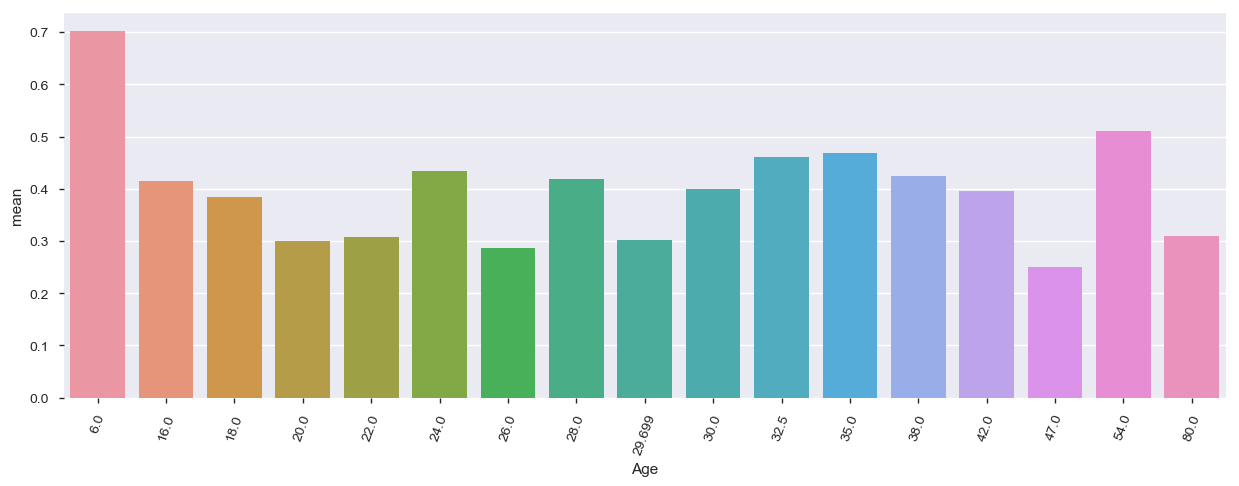

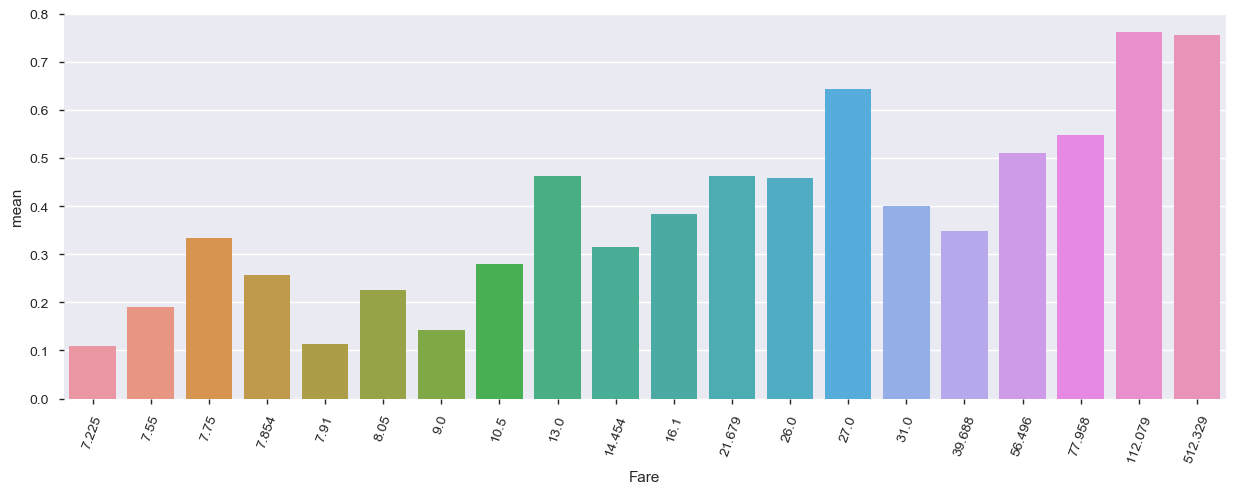

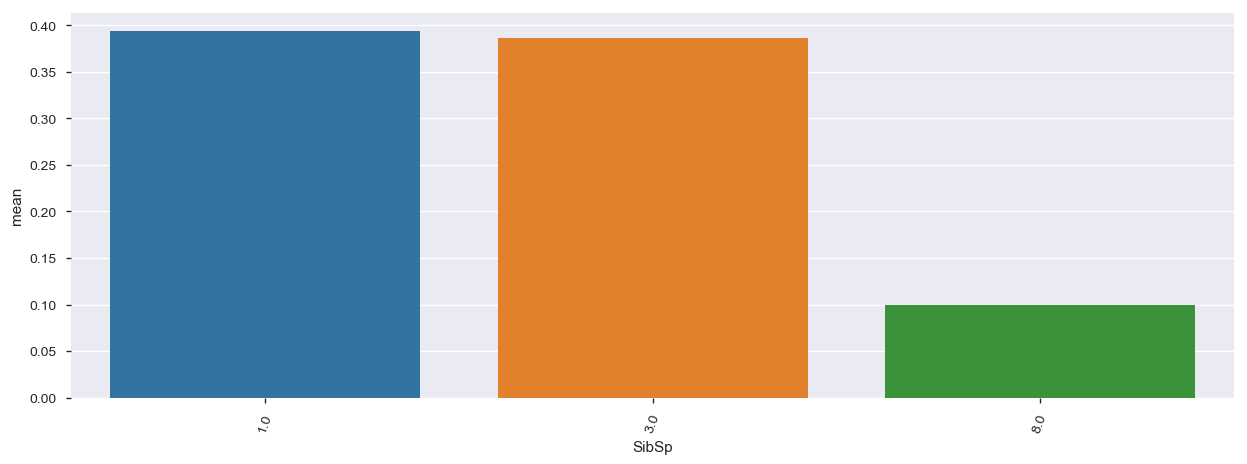

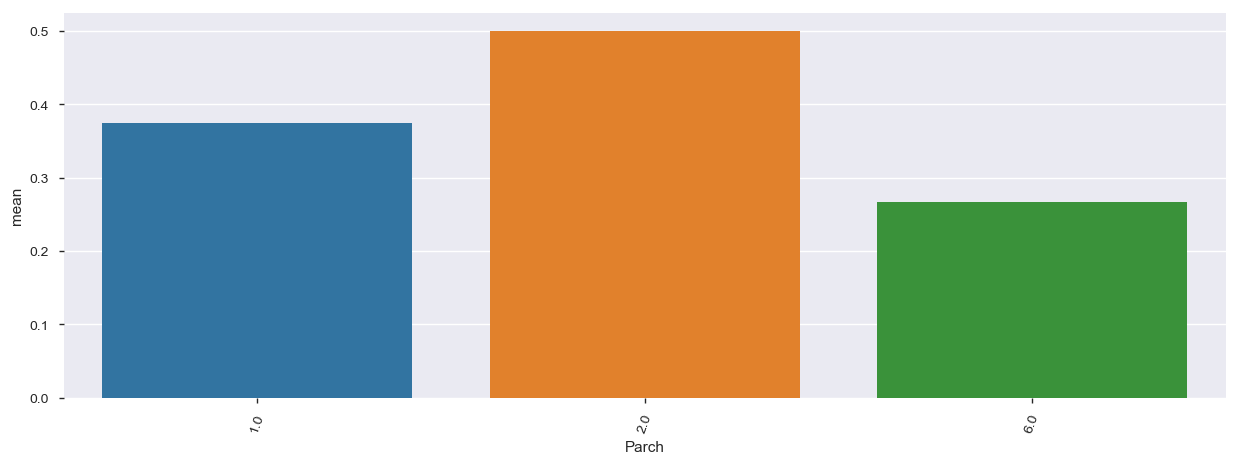

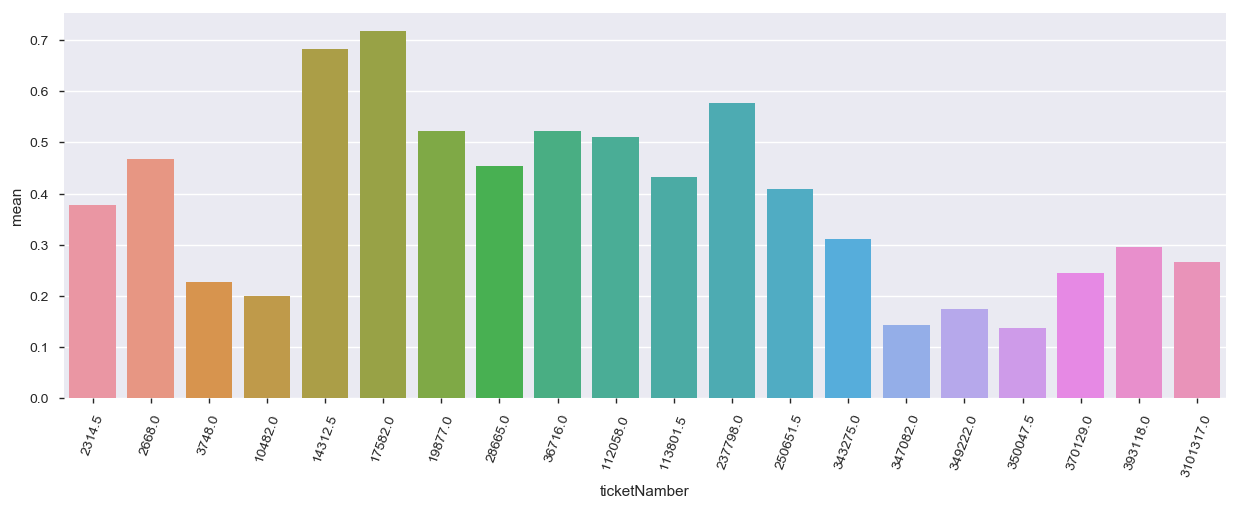

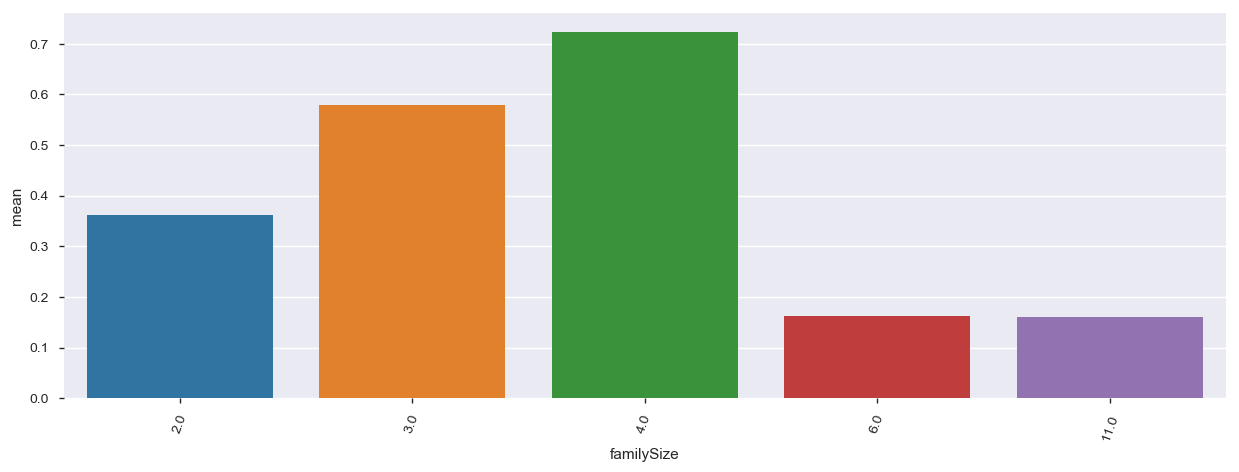

In [22]:
numericFeatures = ['Age', 'Fare', 'SibSp', 'Parch', 'ticketNamber', 'familySize']
for feature in numericFeatures:
    get_bar_plot(fullDf, feature, CLASS_LABEL, q=20)

<a id='correlations'></a>
## Correlations
* Correlations between all the new features

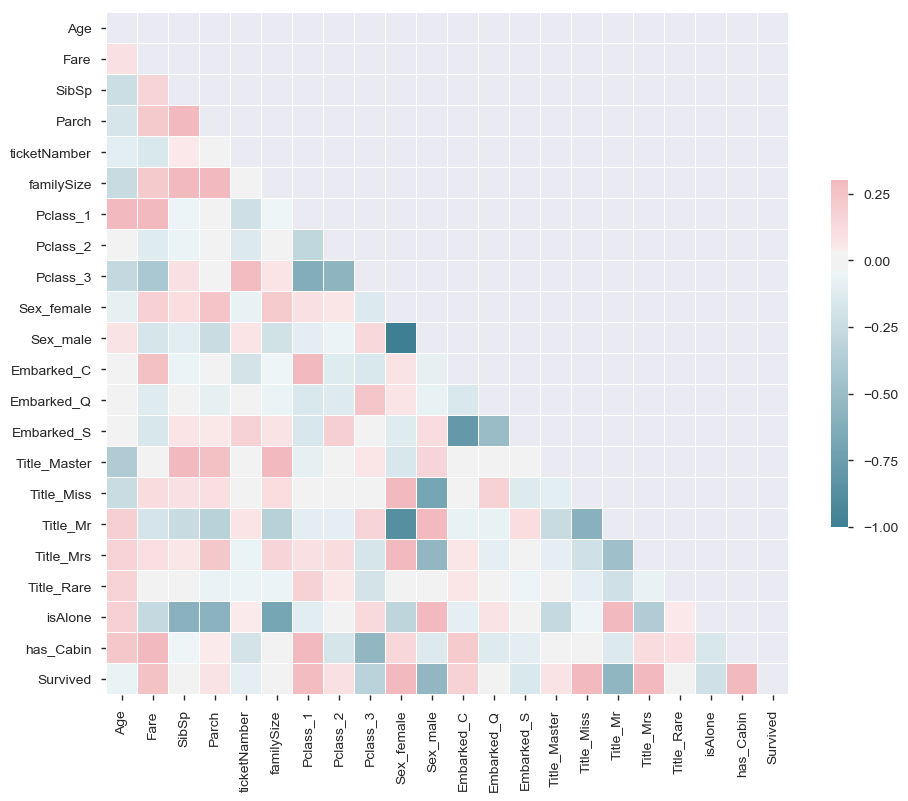

In [23]:
corrDf = fullDf[numericFeatures + categoricalFeaturesDummies + [CLASS_LABEL]].corr()

mask = np.zeros_like(corrDf, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrDf, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<a id='part_5'></a>
# Part 5: Modeling

I'm going to train these classifiers, and then choose the best one using the accuracy score of the cross validation of the grid search:
* Logistic Regression
* Stochastic Gradient Descent
* KNN
* Linear SVM
* RBF SVM
* Naive Bayes
* Decision Tree
* Random Forrest
* Ada Boost
* Neural network
* Gaussian Process

In [24]:
# Leave only the relevant features
featuresToSelect = numericFeatures + categoricalFeaturesDummies
X = X[featuresToSelect]

In [25]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.astype(float))

<a id='model_tuning'></a>
## Models Tuning
* Grid search to maximize accuracy

In [26]:
allModelsTuned = {}
allModelsScores = {}

names = ['Logistic Regression', 'Stochastic Gradient Descent', 'KNN', 'Linear SVM', 'RBF SVM', 
         'Naive Bayes', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Neural Net', 'Gaussian Process']

classifiers = [LogisticRegression(), 
               SGDClassifier(),
               KNeighborsClassifier(), 
               SVC(kernel="linear"), 
               SVC(kernel='rbf'),
               GaussianNB(), 
               DecisionTreeClassifier(), 
               RandomForestClassifier(), 
               AdaBoostClassifier(), 
               MLPClassifier(), 
               GaussianProcessClassifier()]

gridValuesDict = [{'penalty':['l1','l2'], 'C':np.logspace(-4, 2, 10), 'solver': ['liblinear']},
                  {'penalty': ['l1','l2'],'alpha':np.logspace(-4, 2, 10),'max_iter':[1000],'tol':[0.0001,0.001,0.01,0.1,1],'loss':['log']},
                  {'n_neighbors': list(range(1,20))},
                  {'C':np.logspace(-4, 1, 10)},
                  {'C':np.logspace(-4, 1, 10),'gamma':np.logspace(-4, 1, 10)},
                  {},
                  {'min_samples_split':range(10,50,5),'max_depth': range(1,10)},
                  {'n_estimators':list(range(1,10,2)), 'max_depth':[2,3,4,None], 'max_features':list(range(2,8,2)),
                   'min_samples_split':list(range(2,10,2)), 'min_samples_leaf':list(range(1,10,2))},
                  {'n_estimators':list(range(1,100,2))},
                  {'solver': ['lbfgs'], 'max_iter': [1000], 'alpha':np.logspace(-4, 2, 10), 'hidden_layer_sizes':list(range(1,5))},
                  {'kernel': [1.0 * RBF(1.0)]}]

for name, clf, gridValues in zip(names, classifiers, gridValuesDict):
    clfTuned = GridSearchCV(clf, param_grid = gridValues, cv=10, scoring = 'accuracy', iid=False)
    clfTuned.fit(X_scaled, y)
    allModelsTuned[name] = clfTuned.best_estimator_
    allModelsScores[name] = {'Accuracy': clfTuned.best_score_}

<a id='model_selection'></a>
## Model selection

### Check which model works best by the cross validation scores
* Kaggle measure the results in this competition by accuracy

In [27]:
allModelsResultsDf = pd.DataFrame(allModelsScores).T
allModelsResultsDf.sort_values(by='Accuracy',ascending=False)

,Accuracy
Random Forest,0.857501
Neural Net,0.838449
Stochastic Gradient Descent,0.837326
RBF SVM,0.837263
Logistic Regression,0.832806
Gaussian Process,0.831719
AdaBoost,0.831694
Linear SVM,0.830508
Decision Tree,0.827188
KNN,0.823879


In [28]:
bestModelName = allModelsResultsDf.sort_values(by='Accuracy',ascending=False).index[0]
print(f"The best model is: {bestModelName}")
bestClassifier = allModelsTuned.get(bestModelName)
bestFit = bestClassifier.fit(X_scaled, y)

The best model is: Random Forest


<a id='model_plotting'></a>
## Model plotting
* Plots of all the models' results. 
* The graphs and scores below are based on the training data, so the results are likely to indicate an overly optimistic situation.
* I will not use these graphs to decide which model to use, but only the results from the cross validation of the grid search.
* As can be seen in the graphs below, all the models separate the different classes well.

Model: Logistic Regression

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       549
           1       0.80      0.77      0.79       342

   micro avg       0.84      0.84      0.84       891
   macro avg       0.83      0.83      0.83       891
weighted avg       0.84      0.84      0.84       891

AUC: 0.8783274214680599
Accuracy: 0.8406285072951739

[[265  77]
 [ 65 484]]


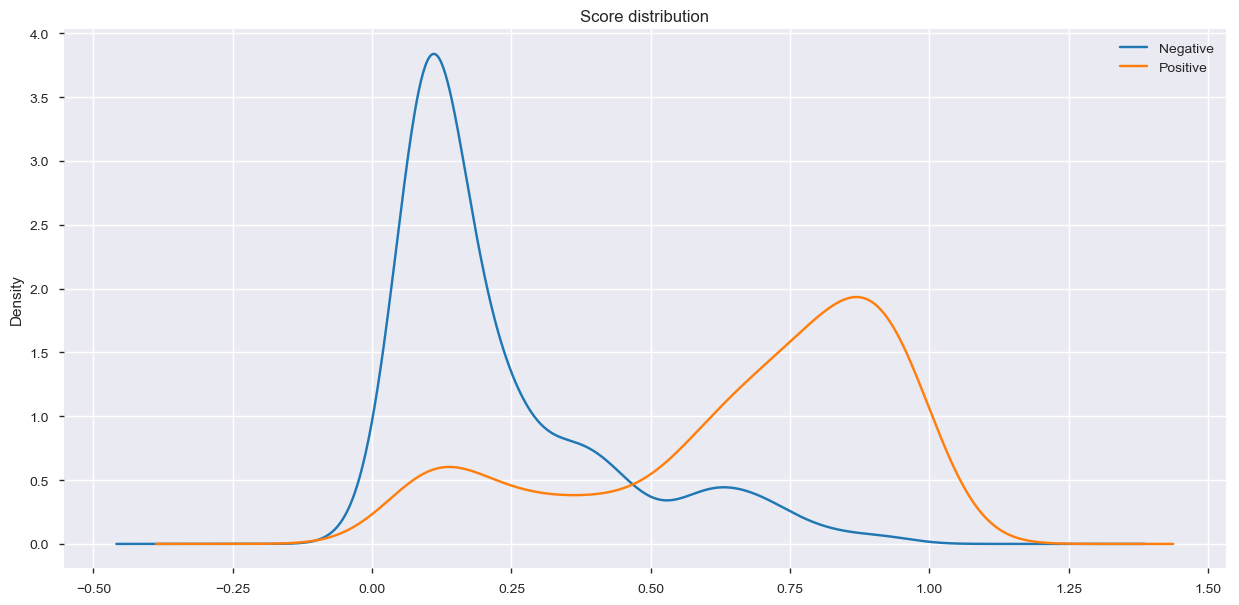

----------------------------------------------------------------------------------------------------
Model: Stochastic Gradient Descent

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       549
           1       0.81      0.77      0.79       342

   micro avg       0.84      0.84      0.84       891
   macro avg       0.84      0.83      0.83       891
weighted avg       0.84      0.84      0.84       891

AUC: 0.8786310037388554
Accuracy: 0.8417508417508418

[[262  80]
 [ 61 488]]


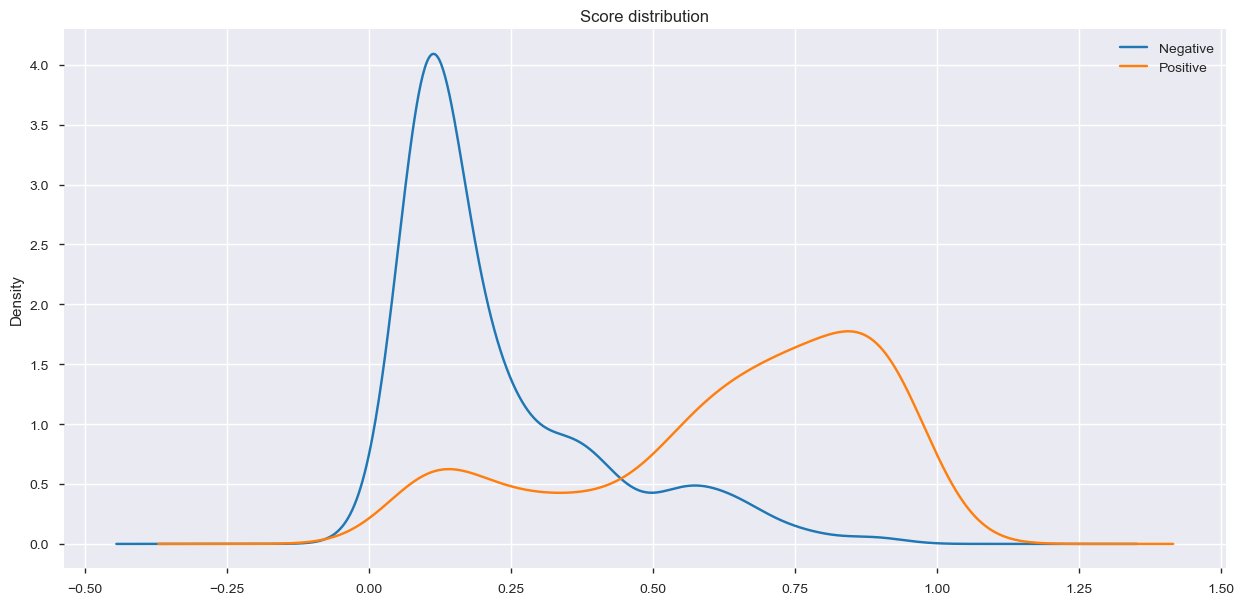

----------------------------------------------------------------------------------------------------
Model: KNN

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       549
           1       0.84      0.76      0.80       342

   micro avg       0.85      0.85      0.85       891
   macro avg       0.85      0.84      0.84       891
weighted avg       0.85      0.85      0.85       891

AUC: 0.9205306831133694
Accuracy: 0.8540965207631874

[[261  81]
 [ 49 500]]


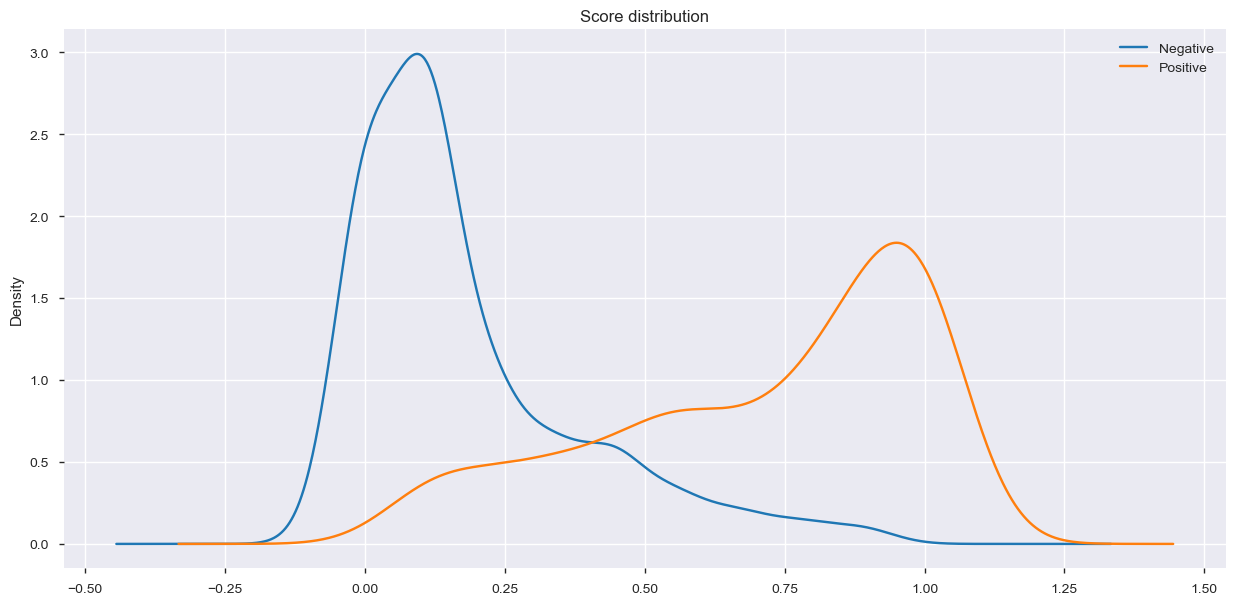

----------------------------------------------------------------------------------------------------
Model: Linear SVM

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       549
           1       0.80      0.74      0.77       342

   micro avg       0.83      0.83      0.83       891
   macro avg       0.82      0.81      0.82       891
weighted avg       0.83      0.83      0.83       891

AUC: 0.8119547502636373
Accuracy: 0.8294051627384961

[[252  90]
 [ 62 487]]


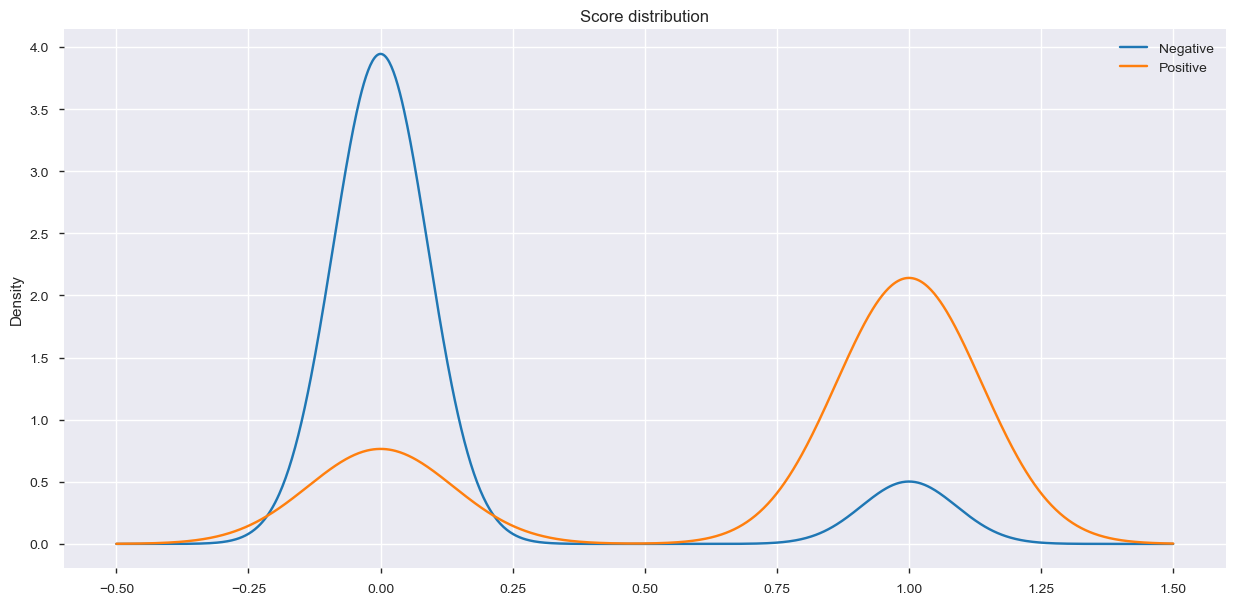

----------------------------------------------------------------------------------------------------
Model: RBF SVM

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       549
           1       0.82      0.74      0.78       342

   micro avg       0.84      0.84      0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891

AUC: 0.8212539545585275
Accuracy: 0.8395061728395061

[[254  88]
 [ 55 494]]


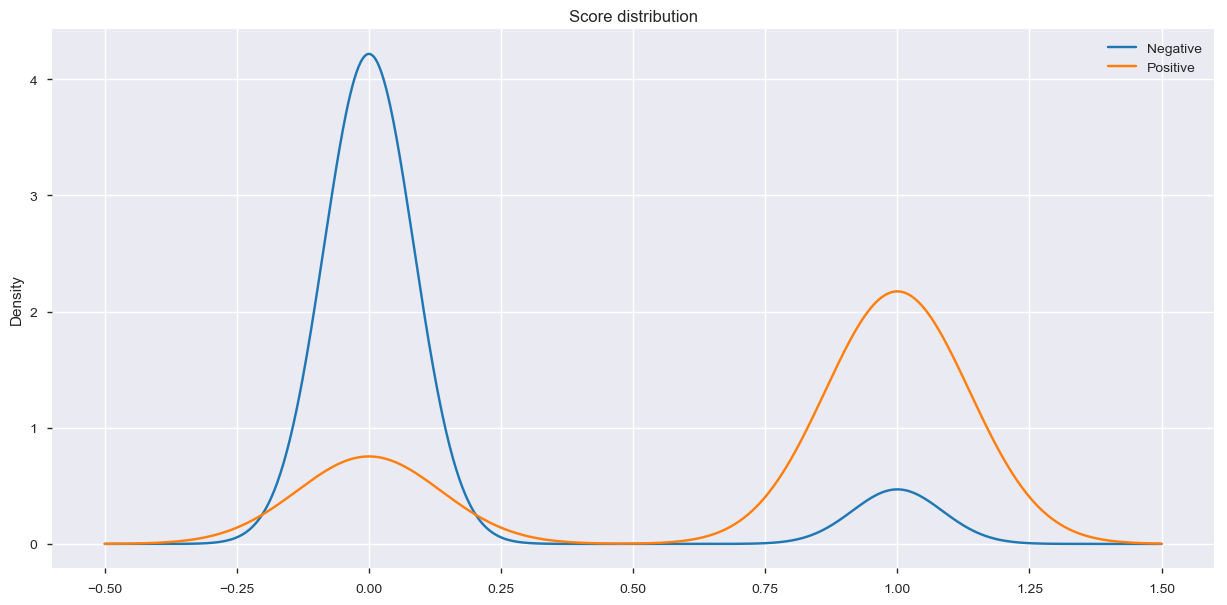

----------------------------------------------------------------------------------------------------
Model: Naive Bayes

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       549
           1       0.73      0.79      0.76       342

   micro avg       0.81      0.81      0.81       891
   macro avg       0.80      0.80      0.80       891
weighted avg       0.81      0.81      0.81       891

AUC: 0.8575346989209514
Accuracy: 0.8080808080808081

[[270  72]
 [ 99 450]]


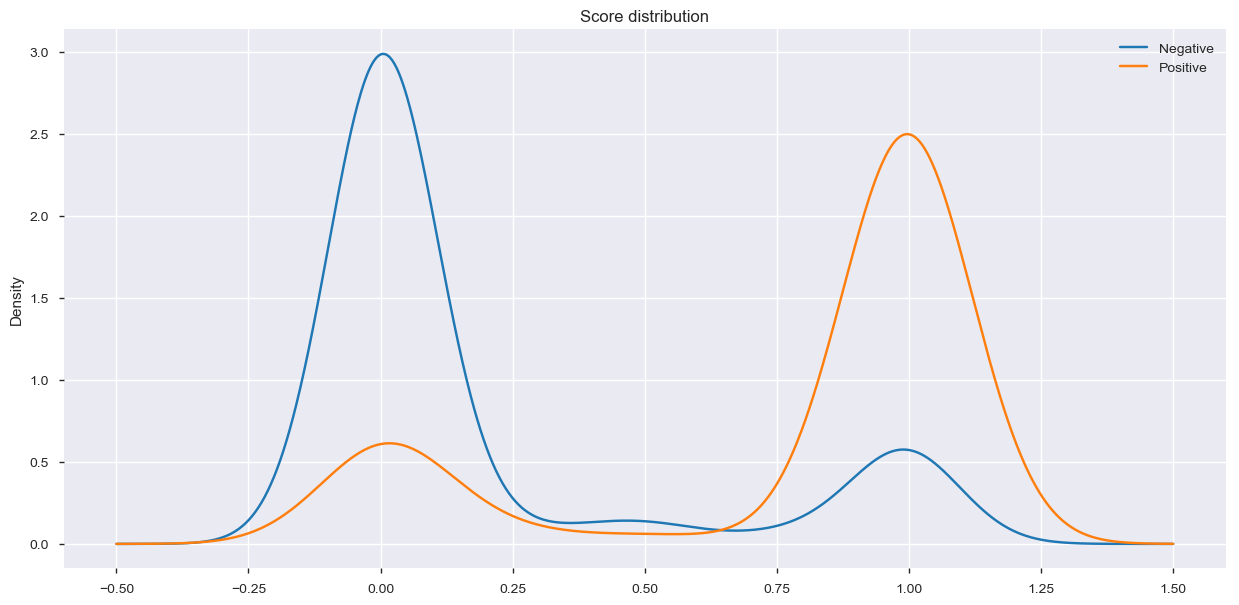

----------------------------------------------------------------------------------------------------
Model: Decision Tree

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       549
           1       0.79      0.80      0.80       342

   micro avg       0.84      0.84      0.84       891
   macro avg       0.83      0.83      0.83       891
weighted avg       0.84      0.84      0.84       891

AUC: 0.9220379424578447
Accuracy: 0.8428731762065096

[[273  69]
 [ 71 478]]


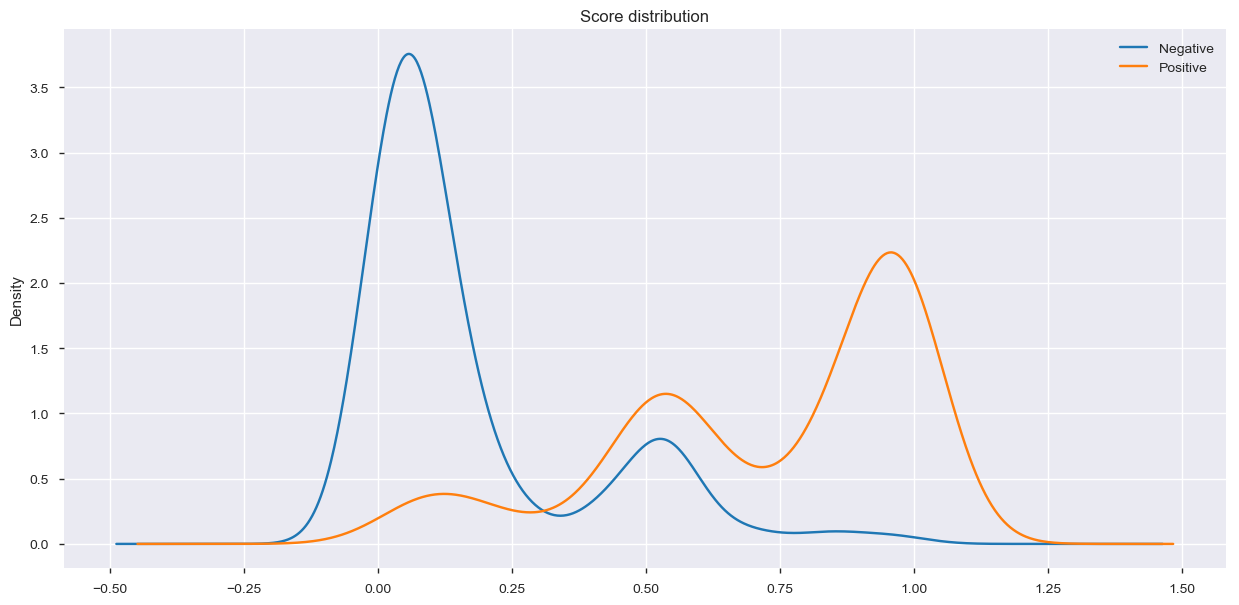

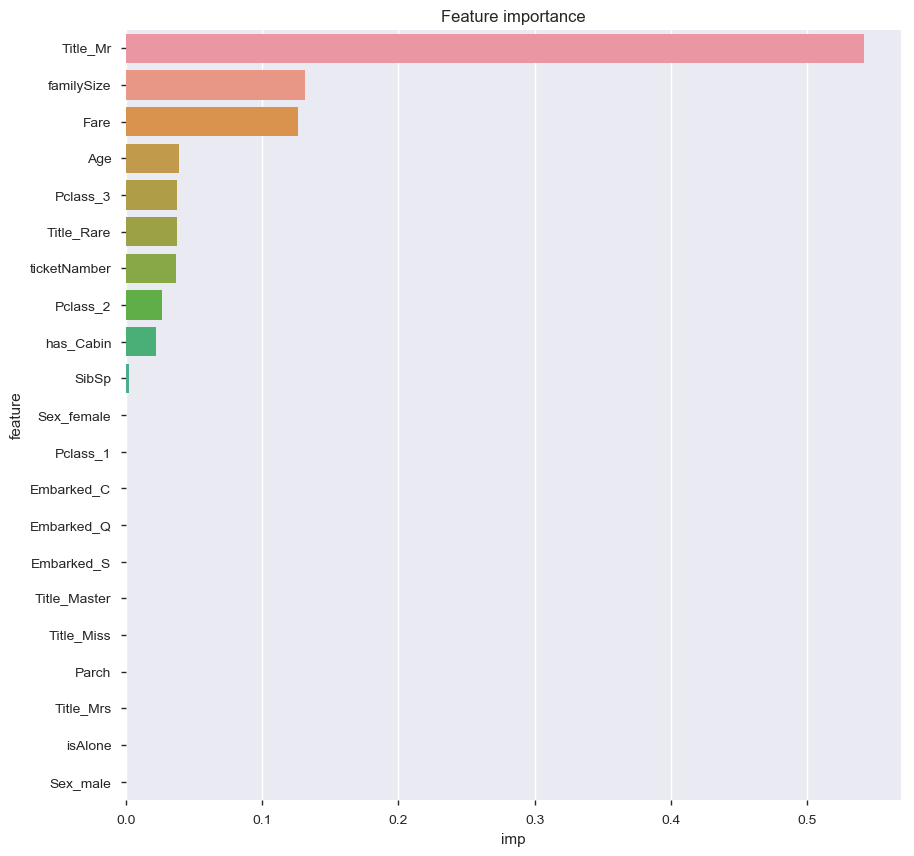

----------------------------------------------------------------------------------------------------
Model: Random Forest

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       549
           1       0.91      0.82      0.86       342

   micro avg       0.90      0.90      0.90       891
   macro avg       0.90      0.88      0.89       891
weighted avg       0.90      0.90      0.90       891

AUC: 0.9671145836662085
Accuracy: 0.898989898989899

[[281  61]
 [ 29 520]]


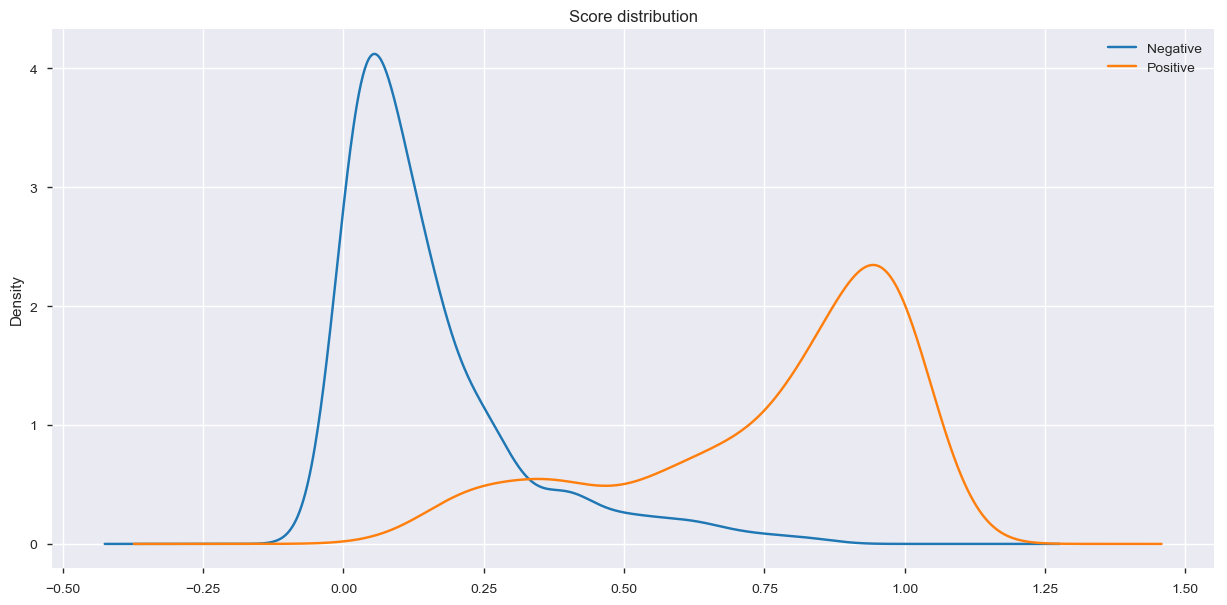

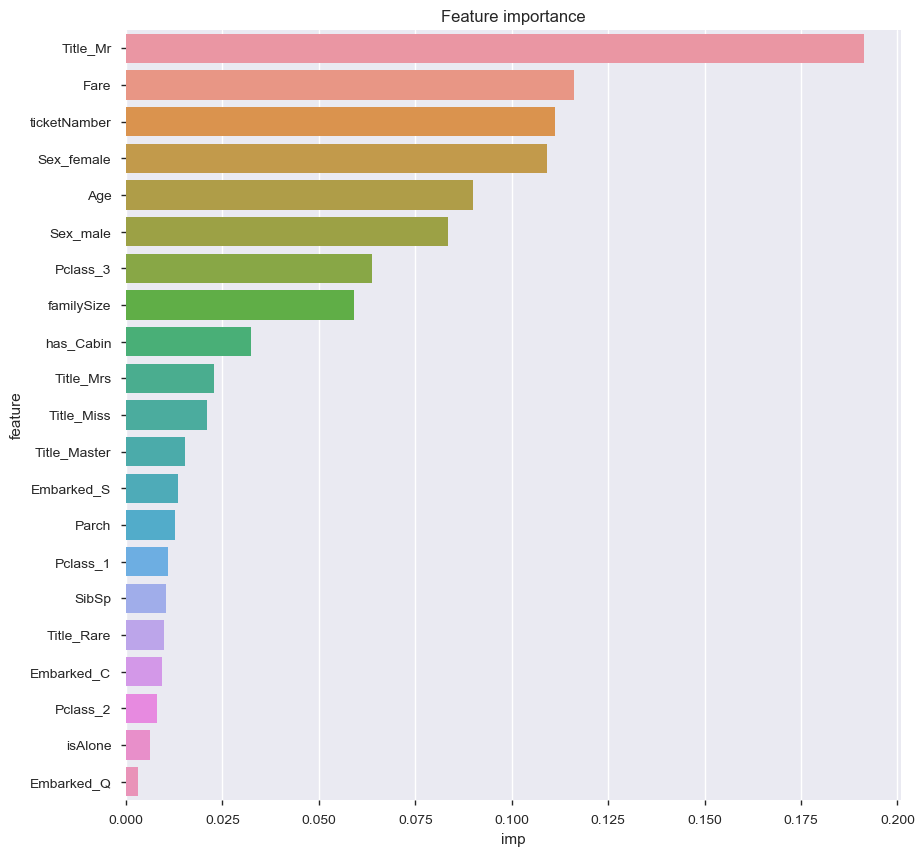

----------------------------------------------------------------------------------------------------
Model: AdaBoost

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       549
           1       0.83      0.83      0.83       342

   micro avg       0.87      0.87      0.87       891
   macro avg       0.86      0.86      0.86       891
weighted avg       0.87      0.87      0.87       891

AUC: 0.9347324747813676
Accuracy: 0.8698092031425365

[[284  58]
 [ 58 491]]


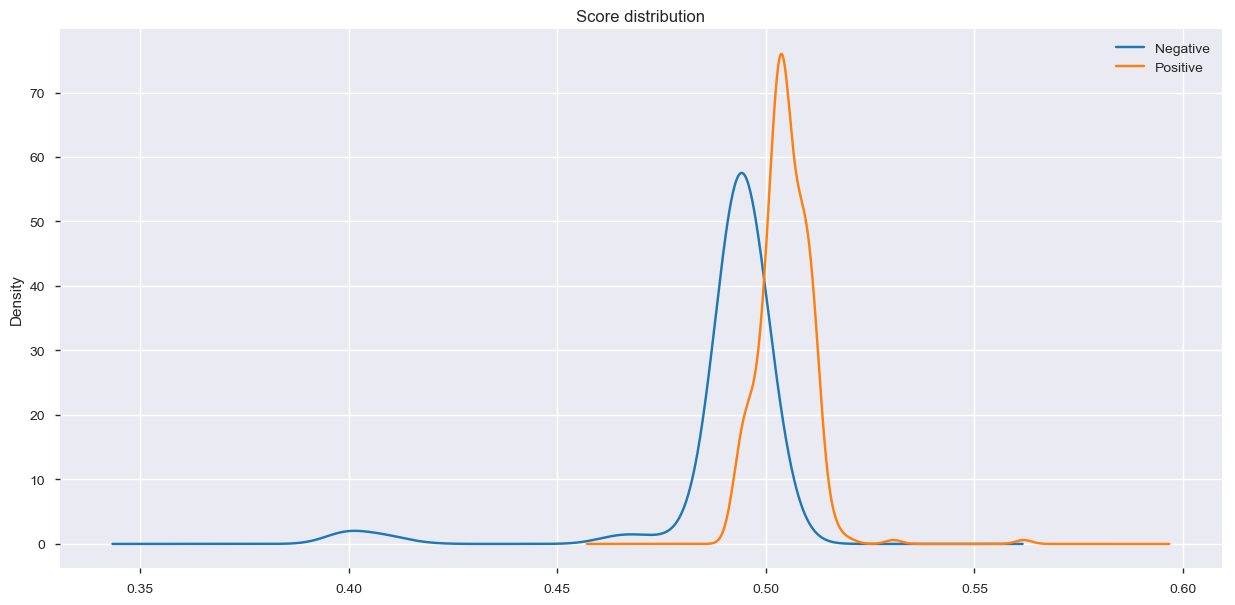

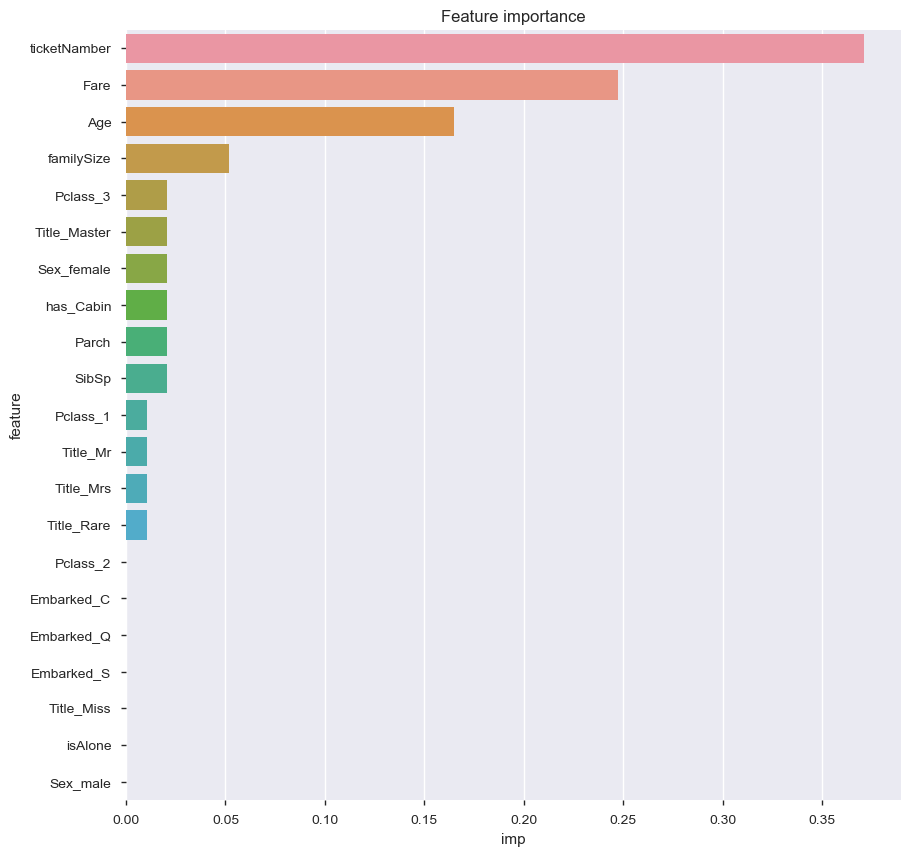

----------------------------------------------------------------------------------------------------
Model: Neural Net

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       549
           1       0.85      0.73      0.78       342

   micro avg       0.85      0.85      0.85       891
   macro avg       0.85      0.82      0.83       891
weighted avg       0.85      0.85      0.84       891

AUC: 0.8888010098105007
Accuracy: 0.8462401795735129

[[248  94]
 [ 43 506]]


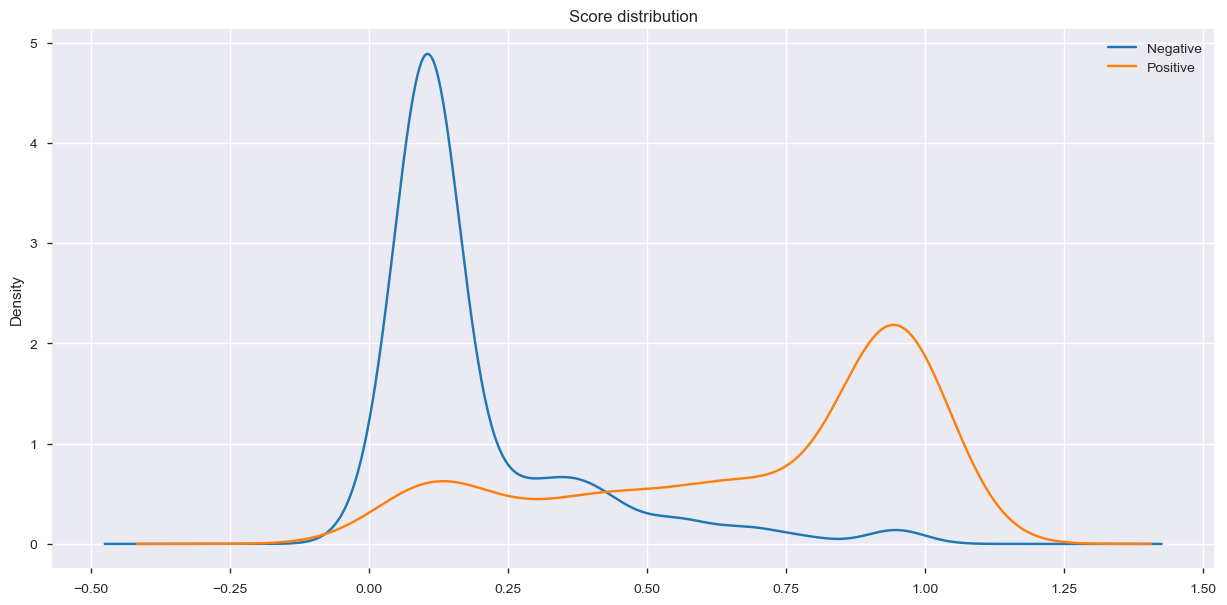

----------------------------------------------------------------------------------------------------
Model: Gaussian Process

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       549
           1       0.86      0.74      0.80       342

   micro avg       0.86      0.86      0.86       891
   macro avg       0.86      0.83      0.84       891
weighted avg       0.86      0.86      0.85       891

AUC: 0.8946942340672568
Accuracy: 0.856341189674523

[[254  88]
 [ 40 509]]


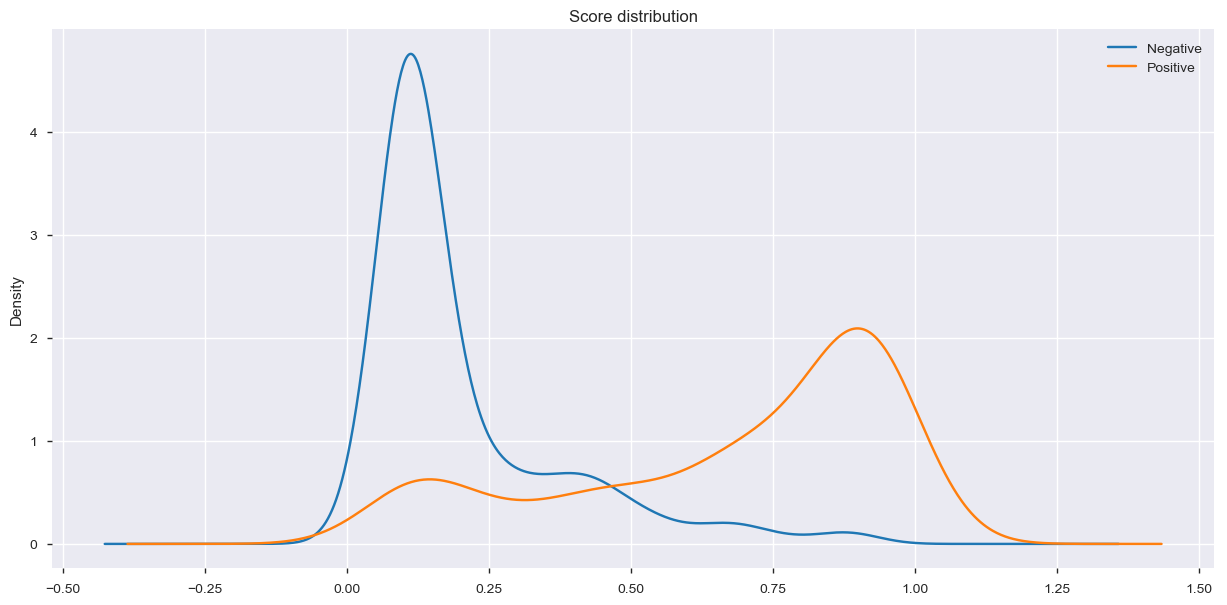

----------------------------------------------------------------------------------------------------


In [29]:
for name, clf in allModelsTuned.items():
   
    print(f"Model: {name}\n")
    plot_model_results(X_scaled, y, clf)
    
    if name in ['Decision Tree', 'Random Forest', 'AdaBoost']:
        plot_feature_importance(X, y, clf)
    
    print("-"*100)

<a id='part_6'></a>
# Part 6: Predict the test data 
* Predict the data in the "test.csv" file using the best fitted model

In [30]:
X_test = pd.read_csv(testFileName)

In [31]:
X_test['Age'] = X_test['Age'].fillna(ageMean)
X_test['Fare'] = X_test['Fare'].fillna(fareMean)
X_test['Embarked'] = X_test['Embarked'].fillna(EmbarkedMostCommon)

X_test['Title'] = X_test['Name'].apply(lambda fullName: fullName.split(', ')[1].split('.')[0])
X_test['ticketNamber'] = X_test['Ticket'].apply(lambda S: get_the_first_number_from_str(S))
X_test['familySize'] = X_test['SibSp'] + X_test['Parch'] + 1
X_test['isAlone'] = X_test['familySize'].apply(lambda x: 1 if x == 1 else 0)
X_test['has_Cabin'] = (~pd.isna(X_test['Cabin'])).astype(int)

categoricalFeatures = ['Pclass', 'Sex', 'Embarked', 'Title'] 
dfGetDummiesTest = pd.get_dummies(X_test[categoricalFeatures].astype(str))
X_test = X_test.merge(dfGetDummiesTest, left_index=True, right_index=True,how='left')

X_test = X_test.set_index('PassengerId')
for column in set(featuresToSelect) - set(X_test.columns):
    X_test[column] = 0
X_test = X_test[featuresToSelect]

X_test_scaled = scaler.transform(X_test.astype(float))

In [32]:
resultsDf = pd.DataFrame({'PassengerId': X_test.index, CLASS_LABEL: bestFit.predict(X_test_scaled)})
resultsDf.to_csv('Titanic_submission.csv', index=False)